# Import Dependencies

In [1]:
import cv2
from matplotlib import pyplot as plt
import random
import os
import numpy as np

# import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [2]:
# Avoid OOM errors by limiting the tensorflow usage of GPU to required limit
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Create Directories for Data

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [12]:
# This creates the floders in the specfied path

directories = [POS_PATH, NEG_PATH, ANC_PATH]
for direc in directories:
    os.makedirs(direc)

# Creating DataSets 

In [35]:
# Move the images downloaded to the respective directory 

for directory in os.listdir(os.path.join('data', 'lfw')):
    for file in os.listdir(os.path.join(os.path.join('data', 'lfw'), directory)):
        EX_PATH = os.path.join(os.path.join('data', 'lfw'), directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# Collect Postive DataSet

In [1]:
import uuid

In [5]:
# Extract images from webcam using Open-CV to create dataset
# NOTE:- NUMBER IN VIDEOCAPTURE MIGHT CHANGE FOR YOU SO KEEP THAT IN MIND

cap = cv2.VideoCapture(0)
while cap.isOpened:
    ret, frame = cap.read()
    
    # this is to make frame sixe 250x250 so that we can get the image in 250x250...   Use this in place of frame size  # frame[120:120+250,200:200+250, :]
    frame = frame[220:90+950, 820:600+850 :]
    
    if cv2.waitKey(1) & 0xFF == ord('a'):
        image_name = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write image to directory 
        cv2.imwrite(image_name, frame)
        
    if cv2.waitKey(1) & 0XFF == ord('p'):
        postive_image_name = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write image to directory 
        cv2.imwrite(postive_image_name, frame)
    
    cv2.imshow('Dataset creation', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [38]:
# Use this only if the image size is not equal to 250x250

import glob
images = glob.glob('{}/*.jpg'.format(os.path.join(POS_PATH)))
for ima in images:
    im = cv2.imread(ima)
    im = cv2.resize(im, (250, 250))
    cv2.imwrite(ima, im)

# Load and Preprocess Data

In [4]:
# Get image directories
import glob
pos_path = glob.glob('{}/*.jpg'.format(os.path.join(POS_PATH)))
anc_path = glob.glob('{}/*.jpg'.format(os.path.join(ANC_PATH)))
neg_path = glob.glob('{}/*.jpg'.format(os.path.join(NEG_PATH)))

# Adding the data into tensorflow data pipeline
anchor = tf.data.Dataset.list_files(anc_path).take(86)
positive = tf.data.Dataset.list_files(pos_path).take(86)
negative = tf.data.Dataset.list_files(neg_path).take(86)

In [5]:
# Preproccessing image

def preprocess(file_path):
    
    # Reading the image from given path
    byte_img = tf.io.read_file(file_path)
    
    # Decoding the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Resizing according to the paper specifications
    img = tf.image.resize(img, (100, 100))
    
    # Scaling the image to be between 0 to 1
    img = img / 255.0
    
    return img

In [6]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

# Build Train and Test Partition

In [7]:
def preprocess_twin(input_image, validation_image, label):
    return(preprocess(input_image), preprocess(validation_image), label)

In [8]:
# # Build data loader pipeline 

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

0.0

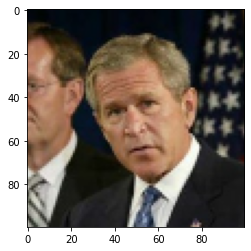

In [9]:
# This is to check the data is corectly mapped 
samples = data.as_numpy_iterator()
sam = samples.next()
plt.imshow(sam[1])
sam[2]

In [10]:
train_data = data.take(round(len(data)* .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [11]:
# Testing partition

test_data = data.skip(round(len(data)* .7))
test_data = test_data.take(round(len(data)* .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Creation 

In [12]:
inp = Input(shape=(100, 100, 3), name='input_image')
conv1 = Conv2D(64, (10, 10), activation='relu')(inp)
max1 = MaxPooling2D(64, (2, 2), padding='same')(conv1)

print(inp)
print(conv1)
print(max1)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 91, 91, 64), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")
KerasTensor(type_spec=TensorSpec(shape=(None, 46, 46, 64), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")


In [13]:
def model_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First conv2D
    conv1 = Conv2D(64, (10, 10), activation='relu')(inp)
    max1 = MaxPooling2D(64, (2, 2), padding='same')(conv1)
    
    # Second conv2D
    conv2 = Conv2D(128, (7, 7), activation='relu')(max1)
    max2 = MaxPooling2D(64, (2, 2), padding='same')(conv2)
    
    # Third conv2D
    conv3 = Conv2D(128, (4, 4), activation='relu')(max2)
    max3 = MaxPooling2D(64, (2, 2), padding='same')(conv3)
    
    # Final conv2D
    conv4 = Conv2D(256, (4, 4), activation='relu')(max3)
    flat1 = Flatten()(conv4)
    dense1 = Dense(4096, activation='sigmoid')(flat1)
    
    return Model(inputs=[inp], outputs=[dense1], name='embedding')

In [14]:
embedding = model_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 128)       26

# Build Distance Layer

In [15]:
# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [16]:
l1 = L1Dist()

In [17]:
def make_saimese_model():
    
    # Anchor image in a network
    input_image = Input(shape=(100, 100, 3), name='input_image')
    
    # Validation image in network
    validation_image = Input(shape=(100, 100, 3), name='validation_image')
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classfication layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SaimeseNetwork')
    

In [18]:
siamese_model = make_saimese_model()

In [19]:
siamese_model.summary()

Model: "SaimeseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

# Training 

In [20]:
# Setup loss function 
binary_cross_entropy_loss = tf.losses.BinaryCrossentropy()

In [21]:
# Steup optimizer function
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.0001

In [22]:
checkpoint_dir = os.path.join('training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

## Build Train Step Function

In [23]:
@tf.function
def tarin_step(batch):
    
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative images
        X= batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        ypred = siamese_model(X, training=True)
        
        # Calculate loss
        loss = binary_cross_entropy_loss(y, ypred)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese_model
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [24]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch{}/{}'.format(epoch, EPOCHS))
        prog_bar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # run train step here
            tarin_step(batch)
            prog_bar.update(idx+1)
            
        # Save checkpoints
        if epoch% 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [25]:
EPOCHS = 50

In [26]:
train(train_data, EPOCHS)


 Epoch1/50
8/8 [==============================] - 10s 417ms/step

 Epoch2/50
8/8 [==============================] - 2s 345ms/step

 Epoch3/50
8/8 [==============================] - 3s 340ms/step

 Epoch4/50
8/8 [==============================] - 3s 334ms/step

 Epoch5/50
8/8 [==============================] - 3s 333ms/step

 Epoch6/50
8/8 [==============================] - 2s 331ms/step

 Epoch7/50
8/8 [==============================] - 3s 335ms/step

 Epoch8/50
8/8 [==============================] - 3s 338ms/step

 Epoch9/50
8/8 [==============================] - 3s 338ms/step

 Epoch10/50
8/8 [==============================] - 3s 339ms/step

 Epoch11/50
8/8 [==============================] - 2s 341ms/step

 Epoch12/50
8/8 [==============================] - 3s 338ms/step

 Epoch13/50
8/8 [==============================] - 3s 339ms/step

 Epoch14/50
8/8 [==============================] - 3s 340ms/step

 Epoch15/50
8/8 [==============================] - 3s 339ms/step

 Epoch16/50
8/8 [

# Evaluate Model

In [27]:
# Import metric calculaltions
from tensorflow.keras.metrics import Precision, Recall

In [34]:
# Get a batch of data
test_input, test_val, test_label = test_data.as_numpy_iterator().next()

In [35]:
# Make predictions
predicted_data = siamese_model.predict([test_input, test_val])
predicted_data

1/1 [==============================] - 0s 20ms/step


array([[2.3993927e-11],
       [9.9964559e-01],
       [9.9944776e-01],
       [3.2799187e-11],
       [5.3344214e-05],
       [6.2541659e-08],
       [6.5250843e-12],
       [1.3448910e-10],
       [9.9995577e-01],
       [6.6557543e-10],
       [9.9995840e-01],
       [4.4730115e-07],
       [9.9995816e-01],
       [5.7203370e-12],
       [4.5905866e-11],
       [9.9982327e-01]], dtype=float32)

In [36]:
# Post processing predicted results
[1 if prediction > 0.5 else 0 for prediction in predicted_data]

[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]

In [37]:
# Actucal data
test_label

array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

In [38]:
# Creating a metric object
recall = Recall()

# Calculating recall value
recall.update_state(test_label, predicted_data)

# Return Recall Result
recall.result().numpy()

1.0

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

In [41]:
# Creating a metric object
precision = Precision()

# Calculating recall value
precision.update_state(test_label, predicted_data)

# Return Recall Result
precision.result().numpy()

1.0

In [42]:
precision = Precision()
recall = Recall()
for test_input, test_val, test_label in test_data.as_numpy_iterator():
    predicted_data = siamese_model.predict([ test_input, test_val])
    precision.update_state(test_label, predicted_data)
    recall.update_state(test_label, predicted_data)

    print('Precision: {}, Recall: {}'.format(precision.result().numpy(), recall.result().numpy()))

1/1 [==============================] - 0s 24ms/step
Precision: 1.0, Recall: 1.0
1/1 [==============================] - 0s 19ms/step
Precision: 1.0, Recall: 1.0
1/1 [==============================] - 0s 17ms/step
Precision: 1.0, Recall: 1.0
1/1 [==============================] - 0s 355ms/step
Precision: 1.0, Recall: 1.0


# Save Model

In [45]:
# Save model weights
siamese_model.save('face_detection.h5')

# Load and Predict using Model

In [47]:
# Reload model
model = tf.keras.models.load_model('face_detection.h5', custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [48]:
model.predict([test_input, test_val])

1/1 [==============================] - 0s 99ms/step


array([[3.27993119e-11],
       [9.98132169e-01],
       [3.98924426e-12],
       [1.03584094e-11]], dtype=float32)

In [49]:
model.summary()

Model: "SaimeseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

# Real Time Test

## Verifcation function

In [75]:
def verify(model, detection_threshold, verification_thershold):
    # Build results array
    results = []
    for image_path in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'verification_images', 'da55ff4e-4214-11ed-8158-362a4c8f52f7.jpg'))
        validation_image = preprocess(os.path.join('application_data', 'verification_images', image_path))
        
        # Make Prediction
        result = model.predict(list(np.expand_dims([input_img, validation_image], axis=1)))
        results.append(result)
    
    # Detection Thershold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verfication Thershold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_thershold
    
    return results, verified
    

# OpenCV Real Time Verification

In [76]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame =  frame[120:120+250,200:200+250, :]
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('v'):
        # Save input image to application_data/input_images folder
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        # Run verification func
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step
True


In [65]:
frame.shape

(480, 640, 3)